In [ ]:
# SciML Tools
using OrdinaryDiffEq, ModelingToolkit, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL, LineSearches

# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111)

StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)

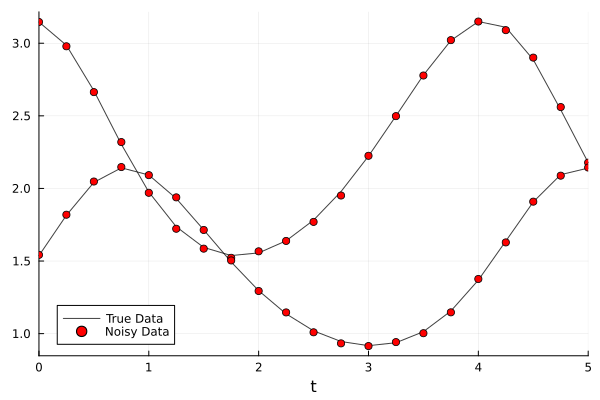

In [ ]:
function lotka!(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α * u[1] - β * u[2] * u[1]
    du[2] = γ * u[1] * u[2] - δ * u[2]
end

# Define the experimental parameter
tspan = (0.0, 5.0)
u0 = 5.0f0 * rand(rng, 2)
p_ = [1.3, 0.9, 0.8, 1.8]

prob = ODEProblem(lotka!, u0, tspan, p_)
solution = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

# Add noise in terms of the mean
X = Array(solution)
t = solution.t

x̄ = mean(X, dims = 2)
noise_magnitude = 5e-3

Xₙ = X .+ (noise_magnitude * x̄) .* randn(rng, eltype(X), size(X))

plot(solution, alpha = 0.75, color = :black, label = ["True Data" nothing])
scatter!(t, transpose(Xₙ), color = :red, label = ["Noisy Data" nothing])

In [ ]:
u0

2-element Vector{Float64}:
 3.1461493970111687
 1.5370475785612603

In [ ]:
rbf(x) = exp.(-(x .^ 2))

# Multilayer FeedForward
const U = Lux.Chain(Lux.Dense(2, 5, rbf), Lux.Dense(5, 5, rbf), Lux.Dense(5, 5, rbf),
    Lux.Dense(5, 2))
# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, U)
const _st = st

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

In [ ]:
# Define the hybrid model
function ude_dynamics!(du, u, p, t, p_true)
    û = U(u, p, _st)[1] # Network prediction
    du[1] = p_true[1] * u[1] + û[1]
    du[2] = -p_true[4] * u[2] + û[2]
end

# Closure with the known parameter
nn_dynamics!(du, u, p, t) = ude_dynamics!(du, u, p, t, p_)
# Define the problem
prob_nn = ODEProblem(nn_dynamics!, Xₙ[:, 1], tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 5.0)
u0: 2-element Vector{Float64}:
 3.1463924566781167
 1.5423300037202508

In [ ]:
function predict(θ, X = Xₙ[:, 1], T = t)
    _prob = remake(prob_nn, u0 = X, tspan = (T[1], T[end]), p = θ)
    Array(solve(_prob, Vern7(), saveat = T,
        abstol = 1e-6, reltol = 1e-6,
        sensealg = QuadratureAdjoint(autojacvec = ReverseDiffVJP(true))))
end

predict (generic function with 3 methods)

In [ ]:
function loss(θ)
    X̂ = predict(θ)
    mean(abs2, Xₙ .- X̂)
end

loss (generic function with 1 method)

In [ ]:
losses = Float64[]

callback = function (state, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

#1 (generic function with 1 method)

In [ ]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.6538559794425964 0.7530555129051208; 0.5314245820045471 -1.146309733390808; … ; 0.6230413317680359 -0.9949618577957153; -0.267433762550354 -0.42296043038368225], bias = [0.6228184700012207, -0.36390432715415955, 0.5564076900482178, -0.6573317050933838, 0.0013557798229157925]), layer_2 = (weight = [-0.6952739953994751 -0.17967917025089264 … 0.24313239753246307 0.001123766996897757; -0.17176459729671478 -0.6643869280815125 … 0.18968744575977325 0.04383226856589317; … ; -0.6787672638893127 -0.4131874442100525 … 0.1658746600151062 -0.5179171562194824; -0.10373302549123764 -0.49185648560523987 … -0.04393347352743149 -0.21508421003818512], bias = [0.0037434629630297422, -0.18621833622455597, -0.20786269009113312, -0.3489077389240265, 0.14812849462032318]), layer_3 = (weight = [-0.5676549077033997 0.2754976153373718 … 0.5977734923362732 -0.04514680802822113; 0.763871967792511 0.0947229415178299 … -0.474456

In [ ]:
res1 = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(eta = 1e-3), callback = callback, maxiters = 5000)
println("Training loss after $(length(losses)) iterations: $(losses[end])")

┌ Warning: Lux.apply(m::AbstractLuxLayer, x::AbstractArray{<:ReverseDiff.TrackedReal}, ps, st) input was corrected to Lux.apply(m::AbstractLuxLayer, x::ReverseDiff.TrackedArray}, ps, st).
│ 
│ 1. If this was not the desired behavior overload the dispatch on `m`.
│ 
│ 2. This might have performance implications. Check which layer was causing this problem using `Lux.Experimental.@debug_mode`.
└ @ LuxCoreArrayInterfaceReverseDiffExt ~/.julia/packages/LuxCore/q0Mrq/ext/LuxCoreArrayInterfaceReverseDiffExt.jl:9


Current loss after 50 iterations: 124231.9420213638
Current loss after 100 iterations: 99525.79353133462
Current loss after 150 iterations: 73986.99608008302
Current loss after 200 iterations: 57253.85902961871
Current loss after 250 iterations: 46433.64120842444
Current loss after 300 iterations: 37891.22625075344
Current loss after 350 iterations: 30743.91701103696
Current loss after 400 iterations: 24605.353250233737
Current loss after 450 iterations: 19422.922187923075
Current loss after 500 iterations: 14986.695033906879
Current loss after 550 iterations: 11212.358093244724
Current loss after 600 iterations: 8098.753689862925
Current loss after 650 iterations: 5665.969091121906
Current loss after 700 iterations: 3872.147911050246
Current loss after 750 iterations: 2601.361977837458
Current loss after 800 iterations: 1721.9534653139515
Current loss after 850 iterations: 1122.8664627491005
Current loss after 900 iterations: 720.5492324163351
Current loss after 950 iterations: 454.51

In [ ]:
optprob2 = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(
    optprob2, LBFGS(linesearch = BackTracking()), callback = callback, maxiters = 5000)
println("Final training loss after $(length(losses)) iterations: $(losses[end])")

# Rename the best candidate
p_trained = res2.u

Current loss after 5050 iterations: 0.5350082415334443
Current loss after 5100 iterations: 0.5348563254467849
Current loss after 5150 iterations: 0.5343960918027088
Current loss after 5200 iterations: 0.5333223863124716
Current loss after 5250 iterations: 0.5325397323570706
Current loss after 5300 iterations: 0.5254699080479595
Current loss after 5350 iterations: 0.5232820544731871
Current loss after 5400 iterations: 0.5219637786381245
Current loss after 5450 iterations: 0.5201989783841574
Current loss after 5500 iterations: 0.4613532924563034
Current loss after 5550 iterations: 0.3773499094673343
Current loss after 5600 iterations: 0.33549469417696437
Current loss after 5650 iterations: 0.28503916588253436
Current loss after 5700 iterations: 0.2719005460057675
Current loss after 5750 iterations: 0.2624859755356046
Current loss after 5800 iterations: 0.2565428564361771
Current loss after 5850 iterations: 0.21398208702126906
Current loss after 5900 iterations: 0.010157170136398677
Curre

ComponentVector{Float64}(layer_1 = (weight = [0.7556834357630815 0.8531656969717503; -0.2611702916003127 -1.498320092980063; … ; -0.3798961854036128 -1.3787799612588865; 0.06449394804047019 0.021820391860839394], bias = [0.7237907630157562, -0.6705225475071609, 0.5867667309489701, -0.9851329786412931, 0.5787325120150097]), layer_2 = (weight = [-0.5478315474652687 0.09804242370137886 … 0.5801774048911267 0.8554750899758021; -0.21288068199346546 -0.8292213605660085 … -0.1657908386905584 0.22969845792863794; … ; -0.6770685369612488 -0.25571207053361517 … 0.32957009572560886 -0.44215851292806774; -0.06797916224795479 -0.30849708895400724 … 0.14282581688122142 -0.4371253878187703], bias = [0.16146754480035372, 0.34111464223671395, 0.8185667273570234, -0.466939187594905, 0.07366078313617726]), layer_3 = (weight = [-1.8828772713089685 -0.3059849712258791 … 1.4624433697234247 0.5948840860160935; 0.6627005207754393 -0.009184550908210581 … -0.6495655455414574 -0.8527206246306471; … ; -1.28895076

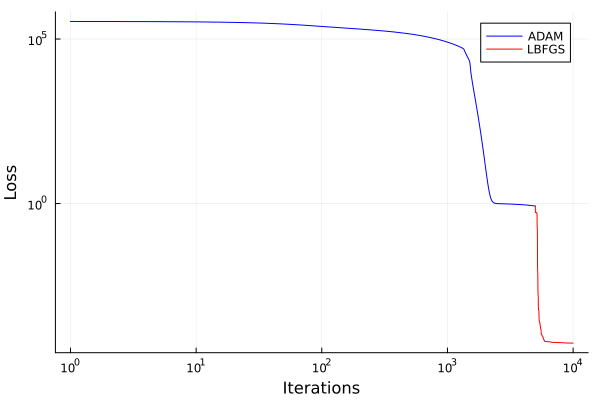

In [ ]:
# Plot the losses
pl_losses = plot(1:5000, losses[1:5000], yaxis = :log10, xaxis = :log10,
    xlabel = "Iterations", ylabel = "Loss", label = "ADAM", color = :blue)
plot!(5001:length(losses), losses[5001:end], yaxis = :log10, xaxis = :log10,
    xlabel = "Iterations", ylabel = "Loss", label = "LBFGS", color = :red)

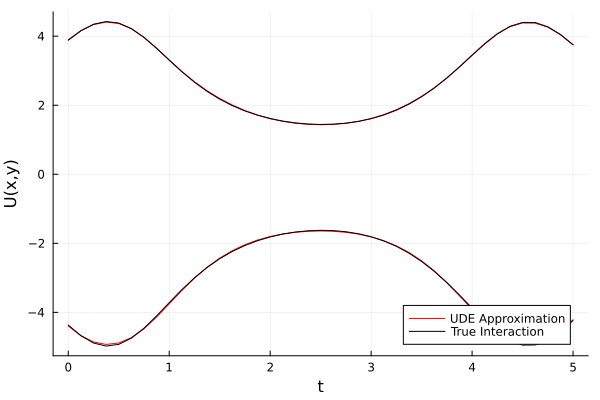

In [ ]:
# Ideal unknown interactions of the predictor
Ȳ = [-p_[2] * (X̂[1, :] .* X̂[2, :])'; p_[3] * (X̂[1, :] .* X̂[2, :])']
# Neural network guess
Ŷ = U(X̂, p_trained, st)[1]

pl_reconstruction = plot(ts, transpose(Ŷ), xlabel = "t", ylabel = "U(x,y)", color = :red,
    label = ["UDE Approximation" nothing])
plot!(ts, transpose(Ȳ), color = :black, label = ["True Interaction" nothing])

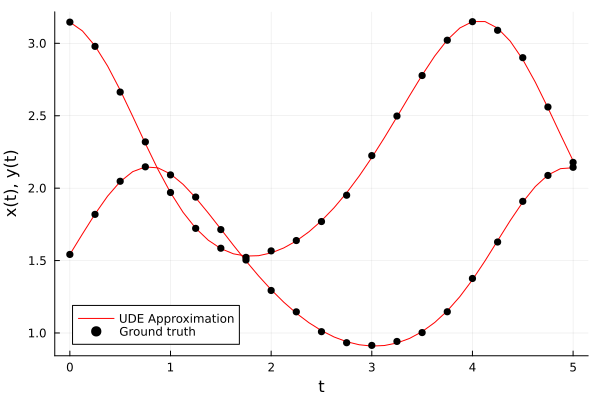

In [ ]:
## Analysis of the trained network
# Plot the data and the approximation
ts = first(solution.t):(mean(diff(solution.t)) / 2):last(solution.t)
X̂ = predict(p_trained, Xₙ[:, 1], ts)
# Trained on noisy data vs real solution
pl_trajectory = plot(ts, transpose(X̂), xlabel = "t", ylabel = "x(t), y(t)", color = :red,
    label = ["UDE Approximation" nothing])
scatter!(solution.t, transpose(Xₙ), color = :black, label = ["Ground truth" nothing])

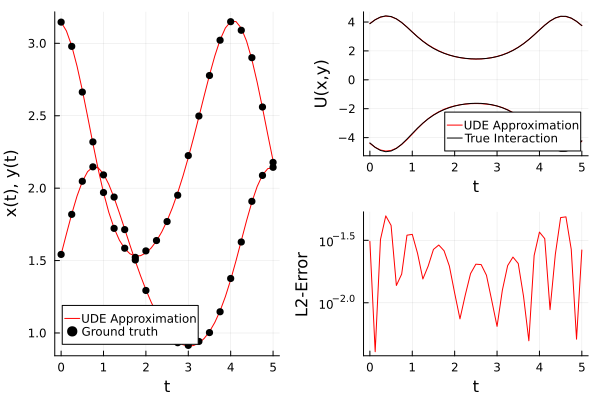

In [ ]:
# Plot the error
pl_reconstruction_error = plot(ts, norm.(eachcol(Ȳ - Ŷ)), yaxis = :log, xlabel = "t",
    ylabel = "L2-Error", label = nothing, color = :red)
pl_missing = plot(pl_reconstruction, pl_reconstruction_error, layout = (2, 1))

pl_overall = plot(pl_trajectory, pl_missing)

In [ ]:
using Symbolics, LinearAlgebra

@variables u1 u2
basis_funcs = [
    u -> 1.0,
    u -> u[1],
    u -> u[1]^2,
    u -> u[1]^3,
    u -> u[1]^4,
    u -> u[2],
    u -> u[1] * u[2],
    u -> u[1]^2 * u[2],
    u -> u[1]^3 * u[2],
    u -> u[2]^2,
    u -> u[2]^2 * u[1],
    u -> u[2]^2 * u[1]^2,
    u -> u[2]^3,
    u -> u[2]^3 * u[1],
    u -> u[2]^4
]

15-element Vector{Function}:
 #5 (generic function with 1 method)
 #6 (generic function with 1 method)
 #7 (generic function with 1 method)
 #8 (generic function with 1 method)
 #9 (generic function with 1 method)
 #10 (generic function with 1 method)
 #11 (generic function with 1 method)
 #12 (generic function with 1 method)
 #13 (generic function with 1 method)
 #14 (generic function with 1 method)
 #15 (generic function with 1 method)
 #16 (generic function with 1 method)
 #17 (generic function with 1 method)
 #18 (generic function with 1 method)
 #19 (generic function with 1 method)

In [ ]:
@variables u₁,u₂

basis_symbols = [
    1,
    u₁,
    u₁^2,
    u₁^3,
    u₁^4,
    u₂,
    u₁ * u₂,
    u₁^2 * u₂,
    u₁^3 * u₂,
    u₂^2,
    u₂^2 * u₁,
    u₂^2 * u₁^2,
    u₂^3,
    u₂^3 * u₁,
    u₂^4
]

15-element Vector{Num}:
             1
            u₁
          u₁^2
          u₁^3
          u₁^4
            u₂
         u₁*u₂
     (u₁^2)*u₂
     (u₁^3)*u₂
          u₂^2
     u₁*(u₂^2)
 (u₁^2)*(u₂^2)
          u₂^3
     u₁*(u₂^3)
          u₂^4

In [ ]:
# Step 1: Use existing X̂ (inputs) and Ŷ (predictions)
X̂ = Array(X̂)  # size (2, T)
Ŷ = Array(Ŷ)  # size (2, T)

T = size(X̂, 2)
inputs = [X̂[:, i] for i in 1:T]      # list of [u1, u2]
targets = [Ŷ[:, i] for i in 1:T]     # list of [ŷ1, ŷ2]

41-element Vector{Vector{Float64}}:
 [-4.3957755867471064, 3.8949293285195115]
 [-4.675170165686699, 4.159956328599054]
 [-4.857111147540175, 4.33711522171208]
 [-4.929526594073721, 4.408576690387129]
 [-4.888157691176108, 4.367185803540325]
 [-4.734050033555446, 4.2153675049302475]
 [-4.476140737936545, 3.967381804914856]
 [-4.136940414767938, 3.6523292693904503]
 [-3.753394960219978, 3.31015787508946]
 [-3.3667884297942, 2.9782633410978265]
 [-3.008539669725046, 2.6790532647939855]
 [-2.6946791447653755, 2.41889967898555]
 [-2.4298809236099337, 2.1955795155653695]
 ⋮
 [-2.800326173609431, 2.5025325713369027]
 [-3.142092612397636, 2.7895804446948684]
 [-3.521465504170985, 3.112497575146567]
 [-3.912467017682609, 3.454567278151938]
 [-4.278354558072705, 3.7859178127801822]
 [-4.581947527203285, 4.070579063933993]
 [-4.795425273715088, 4.276601823249499]
 [-4.903211497314562, 4.382513747888818]
 [-4.898902400288581, 4.377943976818496]
 [-4.781836252528489, 4.262180157565445]
 [-4.557927

In [ ]:
# 4. Build design matrix and solve for β₁ and β₂
Φ = [f(u) for f in basis_funcs, u in inputs]'  # note the transpose

41×15 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0  3.14639  9.89979  31.1486   98.0058   …  3.66887  11.5437    5.6586
 1.0  3.08549  9.52025  29.3747   90.6353      4.77257  14.7257    8.03533
 1.0  2.98216  8.89327  26.5211   79.0902      6.04125  18.016    11.0028
 1.0  2.84305  8.08292  22.9801   65.3335      7.35774  20.9184   14.3107
 1.0  2.67706  7.16662  19.1855   51.3605      8.55509  22.9025   17.4971
 1.0  2.49488  6.22442  15.5292   38.7434   …  9.44961  23.5756   19.978
 1.0  2.30849  5.32915  12.3023   28.3998      9.88891  22.8285   21.2258
 1.0  2.12994  4.53665   9.6628   20.5812      9.8031   20.88     20.9806
 1.0  1.96932  3.87824   7.63751  15.0407      9.23458  18.1859   19.3742
 1.0  1.83306  3.36012   6.1593   11.2904      8.31987  15.2508   16.8586
 1.0  1.72363  2.97088   5.12069   8.82616  …  7.23029  12.4623   13.9811
 1.0  1.64068  2.69182   4.41641   7.2459      6.11334  10.03     11.1782
 1.0  1.58246  2.50419   3.9628    6.27099     5.06673   8

In [ ]:
T = size(X̂, 2)
inputs = [X̂[:, i] for i in 1:T]      # list of [u1, u2]
targets = [Ŷ[:, i] for i in 1:T]     # list of [ŷ1, ŷ2]

41-element Vector{Vector{Float64}}:
 [-4.3957755867471064, 3.8949293285195115]
 [-4.675170165686699, 4.159956328599054]
 [-4.857111147540175, 4.33711522171208]
 [-4.929526594073721, 4.408576690387129]
 [-4.888157691176108, 4.367185803540325]
 [-4.734050033555446, 4.2153675049302475]
 [-4.476140737936545, 3.967381804914856]
 [-4.136940414767938, 3.6523292693904503]
 [-3.753394960219978, 3.31015787508946]
 [-3.3667884297942, 2.9782633410978265]
 [-3.008539669725046, 2.6790532647939855]
 [-2.6946791447653755, 2.41889967898555]
 [-2.4298809236099337, 2.1955795155653695]
 ⋮
 [-2.800326173609431, 2.5025325713369027]
 [-3.142092612397636, 2.7895804446948684]
 [-3.521465504170985, 3.112497575146567]
 [-3.912467017682609, 3.454567278151938]
 [-4.278354558072705, 3.7859178127801822]
 [-4.581947527203285, 4.070579063933993]
 [-4.795425273715088, 4.276601823249499]
 [-4.903211497314562, 4.382513747888818]
 [-4.898902400288581, 4.377943976818496]
 [-4.781836252528489, 4.262180157565445]
 [-4.557927

In [ ]:
Φ = [Float64(f(u)) for u in inputs, f in basis_funcs]
y₁ = reshape(Float64.([y[1] for y in targets]), :, 1)        # size (T × 1)
y₂ = reshape(Float64.([y[2] for y in targets]), :, 1)        # size (T × 1)

41×1 Matrix{Float64}:
 3.8949293285195115
 4.159956328599054
 4.33711522171208
 4.408576690387129
 4.367185803540325
 4.2153675049302475
 3.967381804914856
 3.6523292693904503
 3.31015787508946
 2.9782633410978265
 2.6790532647939855
 2.41889967898555
 2.1955795155653695
 ⋮
 2.5025325713369027
 2.7895804446948684
 3.112497575146567
 3.454567278151938
 3.7859178127801822
 4.070579063933993
 4.276601823249499
 4.382513747888818
 4.377943976818496
 4.262180157565445
 4.04524707096192
 3.751184326149593

In [ ]:
using Convex, SCS

# Step 3: Solve Lasso for y₁
λ = 0.1  # Lasso regularization strength
β₁_var = Convex.Variable(size(Φ, 2), 1)
# β₁_var = Convex.Variable(size(Φ, 2))

prob₁ = minimize(sumsquares(Φ * β₁_var - y₁) + λ * norm(β₁_var, 1))

Convex.solve!(prob₁, SCS.Optimizer)
β₁ = evaluate(β₁_var)

# Step 4: Solve Lasso for y₂
β₂_var = Convex.Variable(size(Φ, 2), 1)
# β₂_var = Convex.Variable(size(Φ, 2))

prob₂ = minimize(sumsquares(Φ * β₂_var - y₂) + λ * norm(β₂_var, 1))

Convex.solve!(prob₂, SCS.Optimizer)
β₂ = evaluate(β₂_var)

------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 31, constraints m: 73
cones: 	  l: linear vars: 30
	  q: soc vars: 43, qsize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 677, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.37e+03  1.00e+00  3.36e+03 -1.68e+03  1.00e-01  5.19e-04 
   250| 2.62e-02  5.82e-04  1.80e-03  9.20e-02  3.27e-01  2.55e-03

[ Info: [Convex.jl] Compilation finished: 0.01 seconds, 395.594 KiB of memory allocated
[ Info: [Convex.jl] Compilation finished: 0.01 seconds, 395.594 KiB of memory allocated


15-element Vector{Float64}:
 -3.901953765596212e-7
 -6.525662334421282e-7
  0.010812004551603669
 -1.1031912664791553e-6
  0.0002034537093486122
  7.877609864922008e-7
  0.7597225126966127
 -7.0673392041512695e-6
 -2.007304155539805e-5
  0.02999669960121586
 -3.5266447545606873e-6
 -1.9377021739441953e-5
  5.138181706738144e-6
 -8.962182755091681e-6
  5.1507238067008755e-6

In [ ]:
using Printf
# Step 5: Thresholding + pretty printing
threshold = 0.1# adjust as needed

function format_expr(β, φs, threshold)
    terms = []
    for (coeff, term) in zip(β, φs)
        if abs(coeff) > threshold
            coeff_str = @sprintf("%f", coeff)
            term_str = string(term)
            push!(terms, coeff_str * "*" * term_str)
        end
    end
    return join(terms, " + ")
end

expr₁_str = format_expr(β₁, basis_symbols, threshold)
expr₂_str = format_expr(β₂, basis_symbols, threshold)

println("📘 Learned symbolic expression for NN output 1 (thresholded):")
println("y₁(t) ≈ ", expr₁_str)

println("\n📘 Learned symbolic expression for NN output 2 (thresholded):")
println("y₂(t) ≈ ", expr₂_str)

📘 Learned symbolic expression for NN output 1 (thresholded):
y₁(t) ≈ -0.882844*u₁*u₂

📘 Learned symbolic expression for NN output 2 (thresholded):
y₂(t) ≈ 0.759723*u₁*u₂


In [ ]:
function lotka_volterra!(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α * u[1] - β * u[2] * u[1]
    du[2] = γ * u[1] * u[2] - δ * u[2]
end

# Initial conditions and time span
tspan = (0.0, 5.0)  # correct for ODEProblem

u0 = [3.1461493970111687,
 1.5370475785612603]
# Actual parameters
params_actual = [1.3, 0.9, 0.8, 1.8]

# Plug in your learned coefficients here (from symbolic regression)
params_learned = [1.3, 0.893595, 0.796093, 1.8]

# Solve actual model
prob_actual = ODEProblem(lotka_volterra!, u0, tspan, params_actual)
sol_actual = solve(prob_actual, Tsit5(), abstol = 1e-12, reltol = 1e-12,saveat = 0.025)

# Solve learned model
prob_learned = ODEProblem(lotka_volterra!, u0, tspan, params_learned)
sol_learned = solve(prob_learned, Tsit5(), abstol = 1e-12, reltol = 1e-12,saveat = 0.025)

retcode: Success
Interpolation: 1st order linear
t: 201-element Vector{Float64}:
 0.0
 0.025
 0.05
 0.075
 0.1
 0.125
 0.15
 0.175
 0.2
 0.225
 0.25
 0.275
 0.3
 ⋮
 4.725
 4.75
 4.775
 4.8
 4.825
 4.85
 4.875
 4.9
 4.925
 4.95
 4.975
 5.0
u: 201-element Vector{Vector{Float64}}:
 [3.1461493970111687, 1.5370475785612603]
 [3.1394208489715782, 1.5642637968531947]
 [3.130793846957667, 1.5917186928172724]
 [3.1202697477890924, 1.6193468061851157]
 [3.107858224284157, 1.6470784683657127]
 [3.0935774678309347, 1.6748400499281284]
 [3.0774543091027025, 1.7025542731034302]
 [3.059524250832788, 1.7301405893492836]
 [3.0398314080209787, 1.7575156205542868]
 [3.018428352615347, 1.7845936610156918]
 [2.995375861586731, 1.811287235701555]
 [2.9707425692974034, 1.8375077088165748]
 [2.9446045271225825, 1.8631659351994094]
 ⋮
 [2.5972058677204215, 2.0798093040201593]
 [2.560809381944882, 2.093013443628027]
 [2.5242188578399274, 2.1047717801661148]
 [2.4875385737961846, 2.1150531031113147]
 [2.45086932

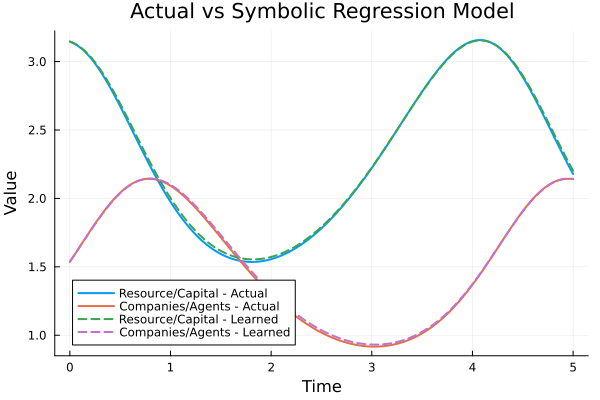

In [ ]:
# Plot comparison
plot(sol_actual.t, sol_actual[1,:], label="Resource/Capital - Actual", lw=2)
plot!(sol_actual.t, sol_actual[2,:], label="Companies/Agents - Actual", lw=2)
plot!(sol_learned.t, sol_learned[1,:], label="Resource/Capital - Learned", ls=:dash, lw=2)
plot!(sol_learned.t, sol_learned[2,:], label="Companies/Agents - Learned", ls=:dash, lw=2)
xlabel!("Time")
ylabel!("Value")
title!("Actual vs Symbolic Regression Model")